<a href="https://colab.research.google.com/github/henrychuks002/Customer-Segmentation-with-AWS/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
plt.style.use('seaborn-white')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture

%matplotlib inline
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "colab"
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
# from google.colab import files
# files.upload()

**Cleaning the Data**

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#importing the data from the mounted drive
df = pd.read_excel("./gdrive/MyDrive/Colab Notebooks/Customer Segmentation/Online Retail.xlsx")
original_df = pd.DataFrame.copy(df)
df.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [8]:
print(df.shape)
df.info()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
#to check the exact amount of missing record in the data
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
#to check all records that has one or more nan values or just an nan values at all 
missingv_df = df[df.isna().any(axis=1)]
missingv_df.head()

InvoiceNo StockCode  ... CustomerID         Country
622     536414     22139  ...        NaN  United Kingdom
1443    536544     21773  ...        NaN  United Kingdom
1444    536544     21774  ...        NaN  United Kingdom
1445    536544     21786  ...        NaN  United Kingdom
1446    536544     21787  ...        NaN  United Kingdom

[5 rows x 8 columns]

In [11]:
#the different ountries that are present in the data
missingv_df['Country'].unique()

array(['United Kingdom', 'EIRE', 'Bahrain', 'Israel', 'Hong Kong',
       'Unspecified', 'France', 'Switzerland', 'Portugal'], dtype=object)

In [12]:
print('Total number of missing Customer ID ',missingv_df.shape[0])
for i in list(missingv_df['Country'].unique()):
    print("Total number of missing Customer ID for "+i,missingv_df[missingv_df['Country']== i].shape[0])

Total number of missing Customer ID  135080
Total number of missing Customer ID for United Kingdom 133600
Total number of missing Customer ID for EIRE 711
Total number of missing Customer ID for Bahrain 2
Total number of missing Customer ID for Israel 47
Total number of missing Customer ID for Hong Kong 288
Total number of missing Customer ID for Unspecified 202
Total number of missing Customer ID for France 66
Total number of missing Customer ID for Switzerland 125
Total number of missing Customer ID for Portugal 39


In [13]:
df.dropna(axis=0, inplace=True)
df.shape

(406829, 8)

In [14]:
#deleting duplicate record and keeping just one
df.drop_duplicates(list(df.columns), keep='first', inplace=True)
df['CustomerID'] = df['CustomerID'].astype(str)
print(df.shape)
print("Quantity columns contains some negative values {}".format(df[df['Quantity']<0].shape))
#removing negative Quantity values
drop = df[df['Quantity']<0]
index_list = list(drop.index)
df.drop(index_list, inplace=True)
df.describe()

(401604, 8)
Quantity columns contains some negative values (8872, 8)


Quantity      UnitPrice
count  392732.000000  392732.000000
mean       13.153718       3.125596
std       181.588420      22.240725
min         1.000000       0.000000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f655c017490>]],
      dtype=object)

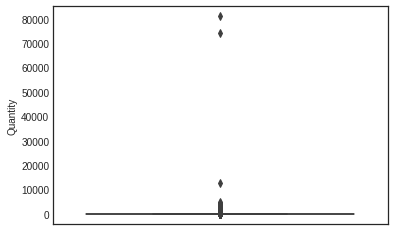

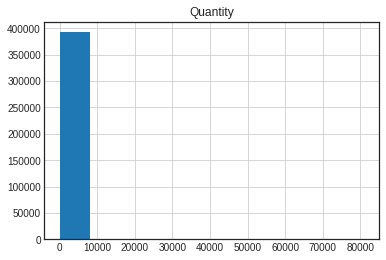

In [15]:
#visualizing Quantity to check for outliers or anomalies
sns.boxplot(y='Quantity', data=df)
print('\n\n')
df.hist(column='Quantity')
#plt.show()

(392729, 8)
14.95
(3723, 8)





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f655c09e310>]],
      dtype=object)

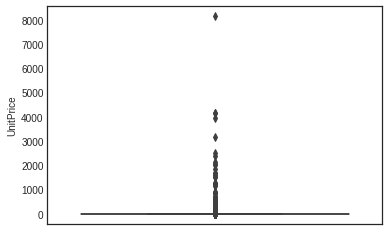

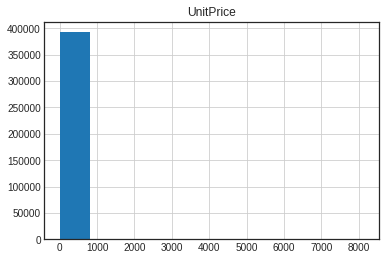

In [16]:
df = df.drop(list(df[df['Quantity']>10000].index), axis=0)
print(df.shape)
print(np.percentile(df['UnitPrice'],[99])[0])
print(df[df['UnitPrice']>np.percentile(df['UnitPrice'],[99])[0]].shape)

#visualizing UnitPrice to check for outliers or anomalies too
sns.boxplot(y='UnitPrice', data=df)
print("\n\n")
df.hist(column='UnitPrice')

In [17]:
'''
Let me tell you the take out from this cell, items at location 144826 and 144828 was bought by the same customer with the same invoice number, at the same time but at different prices
does that make any sense?
makes me feel strange about this "Manual Description"
'''
print(df[df['UnitPrice']>1000].shape)
df[df['UnitPrice']>1000].head()

(21, 8)


InvoiceNo StockCode Description  ...  UnitPrice CustomerID    Country
117054    546328         M      Manual  ...    1687.17    14911.0       EIRE
117055    546329         M      Manual  ...    1687.17    14911.0       EIRE
144826    548813         M      Manual  ...    2382.92    12744.0  Singapore
144828    548813         M      Manual  ...    1252.95    12744.0  Singapore
144829    548820         M      Manual  ...    2053.07    12744.0  Singapore

[5 rows x 8 columns]

In [18]:
df = df.drop(list(df[df['UnitPrice']>1000].index), axis=0)

In [19]:
des = df[df['Description']==df['Description'].str.title()]
#print(des.shape)
#des.head(10)
df = df.drop(list(des.index), axis=0)
print('Dataset shape {} '.format(df.shape))

Dataset shape (392345, 8) 


In [20]:
df.describe()

Quantity      UnitPrice
count  392345.000000  392345.000000
mean       12.721194       2.962478
std        42.942174       5.940544
min         1.000000       0.000000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max      4800.000000     908.160000

**Exploratory Analysis**

In [21]:
df.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [22]:
print("number of unique countries {} ".format(df['Country'].nunique()))
print("number of unique customers {} ".format(df['CustomerID'].nunique()))
#px.pie(df, values="CustomerID", names="Country", title="Pie Chart for Customer countries", color_discrete_sequence= px.colors.sequential.RdBu)
# fig = go.Figure(data=[go.Pie(labels=df.Country, values=df.CustomerID, title="Pie Chart for Customer countries", color_discrete_sequence= px.colors.sequential.RdBu)])
# fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
# fig.show()
print("\n\n")
px_fig = px.histogram(df, x="Country") #to show the country with the largest number of customers
px_fig.show()

number of unique countries 37 
number of unique customers 4333 





In [23]:
'''
Turns out that most of potential customers in the data given are from the UK, the table below show a 90% from the UK
One could obviously guess the company that recorded the data would definitely be from the UK
'''
List = []
for i in df['Country'].unique():
  per = len(df[df['Country']==i])/len(df)
  List.append("%.4f"%per)

Map = [[a,b] for (a,b) in zip(list(df['Country'].unique()), List)]
showcase_df = pd.DataFrame(np.array(Map), columns=['Countries', 'Percent(%)'])
showcase_df.head()

Countries Percent(%)
0  United Kingdom     0.8892
1          France     0.0212
2       Australia     0.0030
3     Netherlands     0.0060
4         Germany     0.0230

In [24]:
df.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [25]:
#I'll do a little feature engineering from this point

df['Total Purchase'] = df['Quantity']*df['UnitPrice']
df.head()

InvoiceNo StockCode  ...         Country  Total Purchase
0    536365    85123A  ...  United Kingdom           15.30
1    536365     71053  ...  United Kingdom           20.34
2    536365    84406B  ...  United Kingdom           22.00
3    536365    84029G  ...  United Kingdom           20.34
4    536365    84029E  ...  United Kingdom           20.34

[5 rows x 9 columns]

In [26]:
'''
Creating a new dataset here that will have only unique customers in it
Done by grouping different columns in the dataset by the customer ID column
'''

new_df = df.groupby(df['CustomerID']).sum()['Total Purchase'].reset_index()
new_df1 = df.groupby(df['CustomerID']).count()['InvoiceNo'].reset_index()
new_df2 = df.groupby(df['CustomerID']).sum()['Quantity'].reset_index()
new_df3 = df[['CustomerID', 'Country']].drop_duplicates('CustomerID', keep='first')

In [27]:
new_df['Frequency'] = new_df1.InvoiceNo
new_df['Product_count'] = new_df2.Quantity
new_df.head()

CustomerID  Total Purchase  Frequency  Product_count
0    12347.0         4310.00        182           2458
1    12348.0         1797.24         31           2341
2    12349.0         1757.55         73            631
3    12350.0          334.40         17            197
4    12352.0         1665.74         82            533

In [28]:
dataset = pd.merge(new_df, new_df3)
dataset.head()

CustomerID  Total Purchase  Frequency  Product_count  Country
0    12347.0         4310.00        182           2458  Iceland
1    12348.0         1797.24         31           2341  Finland
2    12349.0         1757.55         73            631    Italy
3    12350.0          334.40         17            197   Norway
4    12352.0         1665.74         82            533   Norway

In [29]:
group = dataset.groupby('Country').sum()['Total Purchase'].reset_index().sort_values('Total Purchase',ascending=False).reset_index(drop=True)
group.head()

Country  Total Purchase
0  United Kingdom     7004104.313
1     Netherlands      285446.340
2            EIRE      261888.120
3         Germany      226379.150
4          France      199441.940

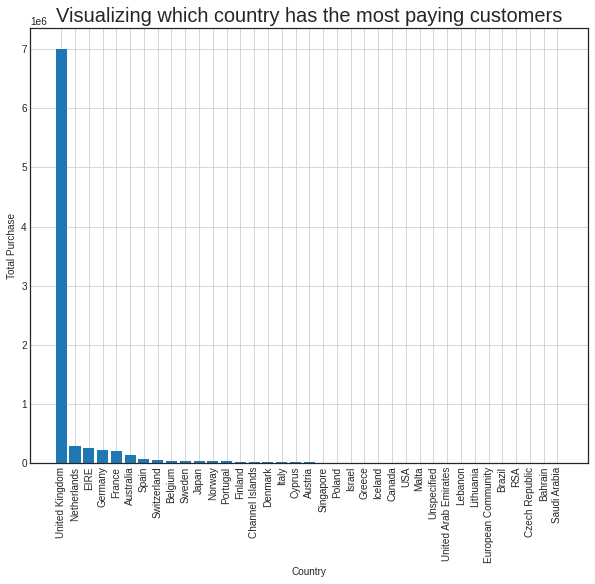

In [30]:
plt.figure(figsize=(10,8))
plt.bar(group['Country'], group['Total Purchase'])
plt.grid()
plt.xlabel("Country")
plt.ylabel("Total Purchase")
plt.xticks(rotation='vertical')
plt.title('Visualizing which country has the most paying customers', fontsize=20)
plt.show()

Text(0.5, 0.98, 'To visualize Products Purchases relationship')

<Figure size 720x576 with 0 Axes>

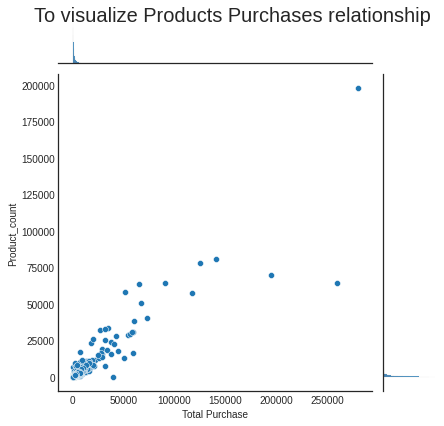

In [31]:
plt.figure(figsize=(10,8))
p = sns.jointplot(x = 'Total Purchase', y = 'Product_count', data = dataset, kind="scatter")
p.fig.suptitle("To visualize Products Purchases relationship", fontsize=20)

Text(0.5, 0.98, 'To visualize Products Frequency relationship')

<Figure size 720x576 with 0 Axes>

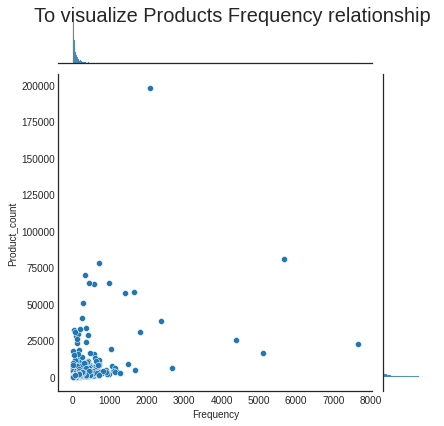

In [32]:
plt.figure(figsize=(10,8))
p = sns.jointplot(x = 'Frequency', y = 'Product_count', data = dataset, kind="scatter")
p.fig.suptitle("To visualize Products Frequency relationship", fontsize=20)

From the plots above, conlusions can be made that sales increase invariably with increasing product count, its natural too, that the more products one sells, the more sales they make. However there is probably no definite pattern in the relationship of how frequent a customer is and how much product they have purchased

Text(0.5, 0.98, 'To visualize Purchases Frequency relationship')

<Figure size 720x576 with 0 Axes>

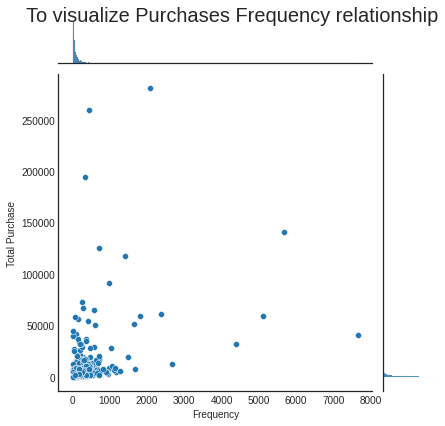

In [33]:
plt.figure(figsize=(10,8))
p = sns.jointplot(x = 'Frequency', y = 'Total Purchase', data = dataset, kind="scatter")
p.fig.suptitle("To visualize Purchases Frequency relationship", fontsize=20)

The plot of Frequeny Purchase relationship and that of Frequency product-count seems somewhat similar, however the higher purchases a customers could make definiely does not depend on their Frequency or regularity. Your most paying customers or customer may not be a regular one

Building the Model

In [34]:
train_data, test_data = np.split(dataset.sample(frac=1, random_state=1), [int(0.85*len(dataset))])
print(train_data.shape, test_data.shape)
# train_data.to_csv("./gdrive/MyDrive/Colab Notebooks/Customer Segmentation/train.csv")
# test_data.to_csv("./gdrive/MyDrive/Colab Notebooks/Customer Segmentation/test.csv")

(3683, 5) (650, 5)


In [35]:
new_train = pd.DataFrame.copy(train_data)
gm_train = pd.DataFrame.copy(train_data)
ms_train = pd.DataFrame.copy(train_data)
rfm_train = pd.DataFrame.copy(train_data)
train_data.head()

CustomerID  Total Purchase  Frequency  Product_count         Country
1213    13992.0           76.80          5             64  United Kingdom
453     12933.0          607.53        106            499  United Kingdom
3080    16553.0         5719.82         84           4600  United Kingdom
632     13183.0         3957.78         94           2208  United Kingdom
3245    16775.0         1691.51        157            439  United Kingdom

In [36]:
encode = LabelEncoder()
for column in list(train_data.columns):
  if train_data[column].dtype == np.object:
    train_data[column] = train_data[column].astype(str)
    train_data[column] = encode.fit_transform(train_data[column])

train_data = train_data[['Total Purchase', 'Frequency', 'Product_count', 'Country']]
train_data.head()

Total Purchase  Frequency  Product_count  Country
1213           76.80          5             64       35
453           607.53        106            499       35
3080         5719.82         84           4600       35
632          3957.78         94           2208       35
3245         1691.51        157            439       35

In [37]:
#transforming the data, reducing its dimension to 2 in order to get a visualization of how the data looks
sc = StandardScaler()
scaled_x = sc.fit_transform(train_data)
scaled_x = pd.DataFrame(scaled_x, columns=train_data.columns)

The next two cells will be determining the expected optimal number of clusters for the train dataset in both kmeans and expectation maximization

Elbow Method for determining optimal kmeans clusters
1 : 14732.0
2 : 9538.265122011884
3 : 6174.80679521777
4 : 4721.401442232091
5 : 3466.049803260887
6 : 2587.8756583622944
7 : 2025.8891037759486
8 : 1702.0575524704109
9 : 1451.4751947572317
10 : 1309.0119259925996


Silhouette coefficient method for determining optimal kmeans cluster
2: 0.9289844564793522
3: 0.8159470969193211
4: 0.8159470969193211
5: 0.8207331853170949
6: 0.7732945139796895
7: 0.7580386849878659
8: 0.7567081287409051
9: 0.6883542058918444
10: 0.5962971764534946
11: 0.6209778526472027





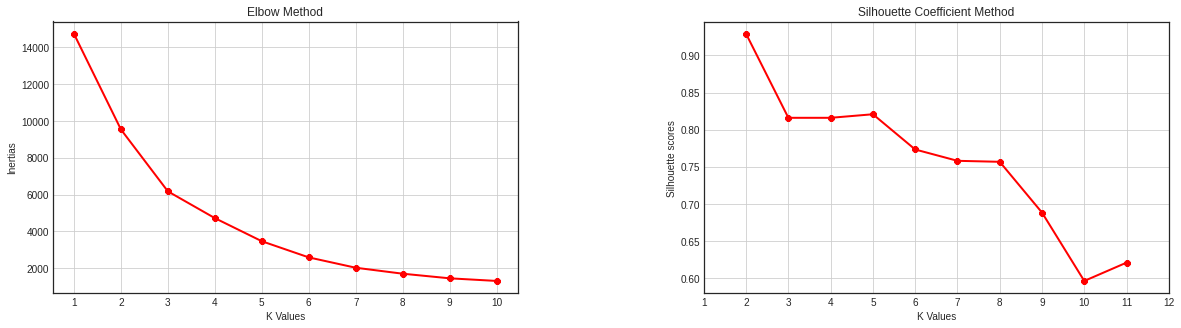

In [38]:
inertias = []
mapping = {}
for k in range(1, 11):
  kmeans = KMeans(n_clusters = k)
  kmeans.fit(scaled_x)
  inertias.append(kmeans.inertia_)
  mapping[k] = kmeans.inertia_

print("Elbow Method for determining optimal kmeans clusters")
for key, value in mapping.items():
  print(f'{key} : {value}')


map = {}
scores = []
for i in range(2, 12):
  kmeans_n = KMeans(n_clusters=i, random_state=1)
  labels = kmeans_n.fit(scaled_x).labels_
  score = metrics.silhouette_score(scaled_x, labels, metric='euclidean', sample_size=1000, random_state=1)
  scores.append(score)
  map[i] = score

print("\n\nSilhouette coefficient method for determining optimal kmeans cluster")
for key_, val_ in map.items():
  print(f'{key_}: {val_}')

print("\n\n")
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.grid()
plt.plot(range(1,11),inertias, linewidth=2, color="red", marker ="8")
plt.xlabel("K Values")
plt.title("Elbow Method")
plt.xticks(np.arange(1,11,1))
plt.ylabel("Inertias")

plt.subplot(1,2,2)
plt.subplots_adjust(wspace=0.4)
plt.grid()
plt.plot(range(2,12),scores, linewidth=2, color="red", marker ="8")
plt.xlabel("K Values")
plt.title("Silhouette Coefficient Method")
plt.xticks(np.arange(1,13,1))
plt.ylabel("Silhouette scores")
# n = np.argmax(scores) * 2
# plt.axvline(x=n, linestyle='--', c='blue', linewidth=3, label='Optimal number of clusters ({})'.format(n))
# plt.scatter(n, scores[n-3], c='green', s=400)
# plt.legend(shadow=True)

plt.show()

The output of the silhouette coefficient method of determining optimal number of clusters as shown above (right) makes more sense, as its detecting about 3 optimal clusters, however with the elbow method (left), definitely difficult to, next is to try the BIC AIC method of determing optimal number of clusters, for KMeans we'll stick with about 3 clusters as shown with the silhouette coefficient method result above (right) 

Text(0.5, 0, 'n_components')

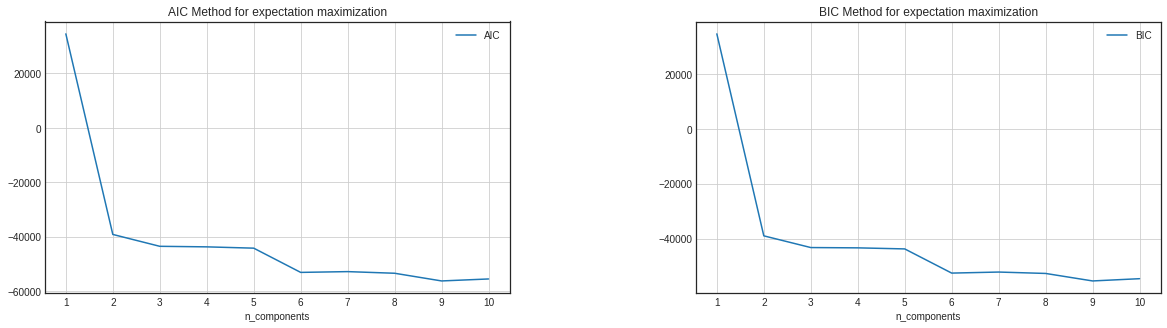

In [39]:
n_components = np.arange(1, 11)
models = [sklearn.mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(scaled_x)
          for n in n_components]

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.grid()
plt.plot(n_components, [m.aic(scaled_x) for m in models], label='AIC')
plt.legend(loc='best')
plt.title("AIC Method for expectation maximization")
plt.xticks(np.arange(1,11,1))
plt.xlabel('n_components')

plt.subplot(1,2,2)
plt.subplots_adjust(wspace=0.4)
plt.grid()
plt.plot(n_components, [m.bic(scaled_x) for m in models], label='BIC')
plt.legend(loc='best')
plt.title("BIC Method for expectation maximization")
plt.xticks(np.arange(1,11,1))
plt.xlabel('n_components')

The BIC AIC method as shown above detects about 3 optimal clusters. so we may probably go with 3 clusters too in this case

The next will be to try for hierachical clustering. I believe we'll come to a conclusion on which algorithm will be fit and cluster the data

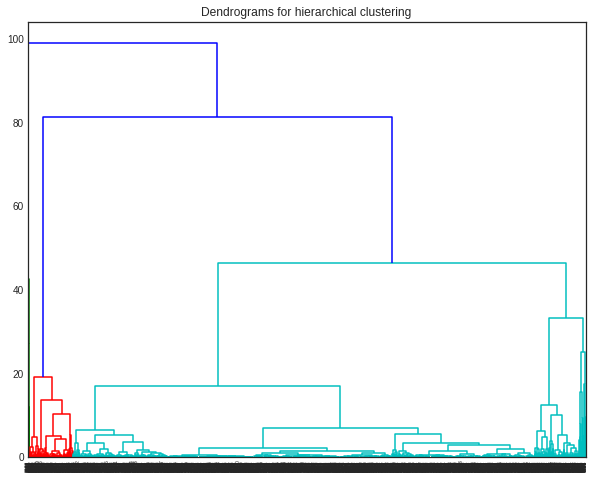

In [40]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 8))
plt.title("Dendrograms for hierarchical clustering")
dend = shc.dendrogram(shc.linkage(scaled_x, method='ward'))

Hierarchical clustering detected 3 clusters to (best guess). So I'll go with 3 clusters for hierarchical cluster. However, results later on will show which algorithm clusters makes more sense

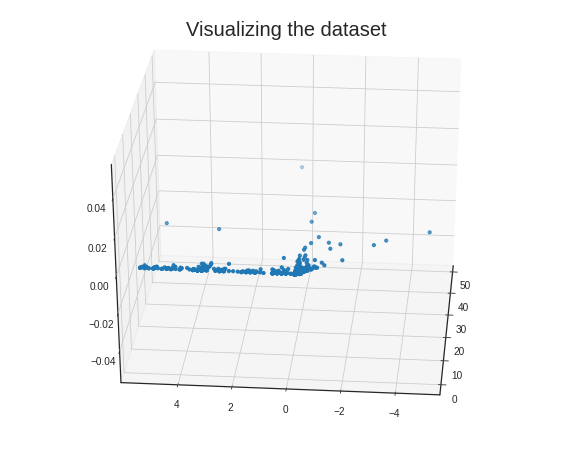

In [68]:
pca = PCA(n_components=2)
pca.fit(scaled_x)
X = pca.transform(scaled_x)

fig = plt.figure(edgecolor='k', figsize = (10,8))
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], s=10)
ax.set_title("Visualizing the dataset", fontdict={'fontsize':20})
ax.view_init(30,185)

In [42]:
#building the kmeans
clf = KMeans(n_clusters=3, init='random')
clf.fit(scaled_x)
labels = clf.labels_
cluster_centers = clf.cluster_centers_

In [43]:
scaled_x.columns

Index(['Total Purchase', 'Frequency', 'Product_count', 'Country'], dtype='object')

In [44]:
new_X = pd.DataFrame(X, columns=["pca_one","pca_two"])
print(new_X.shape)
new_X.head()

(3683, 2)


pca_one   pca_two
0 -0.467824 -0.235811
1 -0.177983 -0.297112
2  0.678023 -0.285138
3  0.261246 -0.290347
4 -0.008899 -0.327916

In [45]:
new_X['labels'] = labels
new_X.labels.unique()

array([1, 2, 0], dtype=int32)

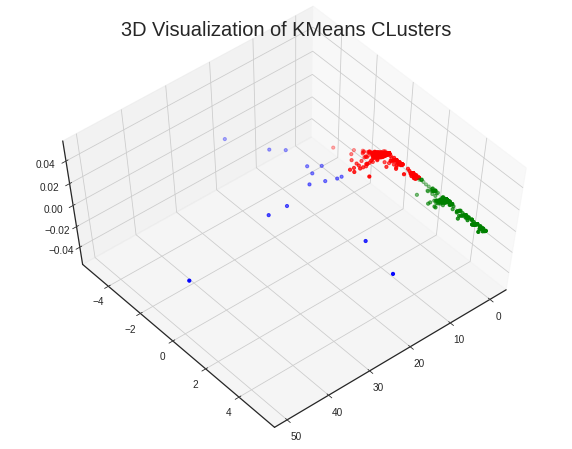

In [46]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_X.pca_one[new_X.labels == 0], new_X.pca_two[new_X.labels == 0], c='blue', s=10)
ax.scatter(new_X.pca_one[new_X.labels == 1], new_X.pca_two[new_X.labels == 1], c='red', s=10)
ax.scatter(new_X.pca_one[new_X.labels == 2], new_X.pca_two[new_X.labels == 2], c='green', s=10)
ax.set_title("3D Visualization of KMeans CLusters", fontdict={'fontsize':20})
ax.view_init(60, 50)
fig.show()

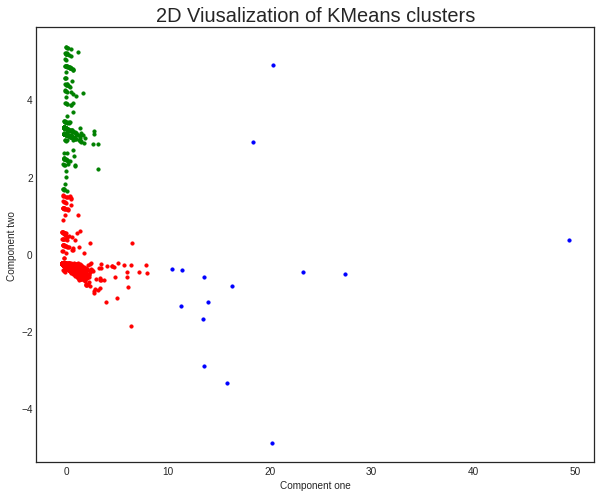

In [47]:
#2d visualization

plt.figure(figsize = (10,8))
plt.scatter(new_X.pca_one[new_X.labels == 0], new_X.pca_two[new_X.labels == 0], c='blue', s=10)
plt.scatter(new_X.pca_one[new_X.labels == 1], new_X.pca_two[new_X.labels == 1], c='red', s=10)
plt.scatter(new_X.pca_one[new_X.labels == 2], new_X.pca_two[new_X.labels == 2], c='green', s=10)
plt.title("2D Viusalization of KMeans clusters", fontsize=20)
plt.xlabel("Component one", fontsize=10)
plt.ylabel("Component two", fontsize=10)
plt.show()

In [48]:
gmm_X = pd.DataFrame(X, columns=["pca_one","pca_two"])
print(gmm_X.shape)

(3683, 2)


In [55]:
#building Expectation maximization
gmm = GaussianMixture(n_components=3, covariance_type="full", max_iter=10, init_params='kmeans')
gmm.fit(scaled_x)
gmm_labels = gmm.predict(scaled_x)

In [56]:
gmm_X['labels'] = gmm_labels

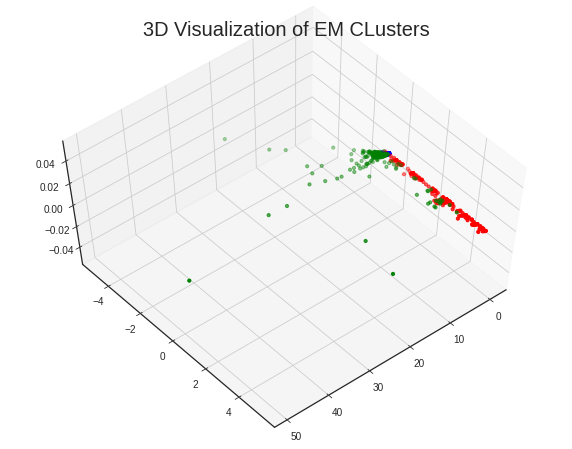

In [57]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gmm_X.pca_one[gmm_X.labels == 0], gmm_X.pca_two[gmm_X.labels == 0], c='blue', s=10)
ax.scatter(gmm_X.pca_one[gmm_X.labels == 1], gmm_X.pca_two[gmm_X.labels == 1], c='red', s=10)
ax.scatter(gmm_X.pca_one[gmm_X.labels == 2], gmm_X.pca_two[gmm_X.labels == 2], c='green', s=10)
ax.set_title("3D Visualization of EM CLusters", fontdict={'fontsize':20})
ax.view_init(60, 50)
fig.show()

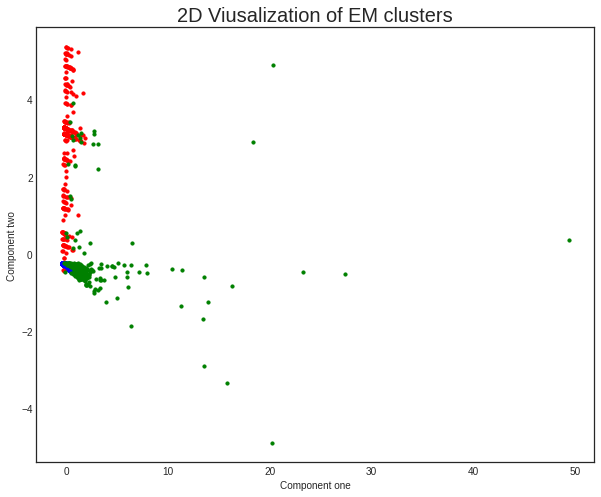

In [58]:
#2D visualiszation of EM clusters

fig = plt.figure(figsize=(10,8))
plt.scatter(gmm_X.pca_one[gmm_X.labels == 0], gmm_X.pca_two[gmm_X.labels == 0], c='blue', s=10)
plt.scatter(gmm_X.pca_one[gmm_X.labels == 1], gmm_X.pca_two[gmm_X.labels == 1], c='red', s=10)
plt.scatter(gmm_X.pca_one[gmm_X.labels == 2], gmm_X.pca_two[gmm_X.labels == 2], c='green', s=10)
plt.title("2D Viusalization of EM clusters", fontsize=20)
plt.xlabel("Component one", fontsize=10)
plt.ylabel("Component two", fontsize=10)
plt.show()

In [59]:
#Building with Meanshift

ms = MeanShift()
ms.fit(scaled_x)
ms_centers = ms.cluster_centers_
ms_labels = ms.labels_

In [60]:
ms_X = pd.DataFrame(X, columns=["pca_one","pca_two"])
print(ms_X.shape)

ms_X['labels'] = np.nan
for i in range(len(ms_X)):
  ms_X['labels'].iloc[i] = ms_labels[i]

print('Unique labels ',ms_X['labels'].unique())

(3683, 2)
Unique labels  [ 0.  2.  3.  1. 52. 46. 47. 12. 43.  5.  6. 40. 44.  4. 10. 13. 23. 49.
 51.  8. 11. 21. 38. 33.  9. 24. 41. 50. 16. 39.  7. 19. 17. 48. 14. 30.
 25. 26. 28. 34. 31. 36. 22. 29. 37. 35. 20. 15. 27. 32. 42. 18. 45.]


Ok Meanshift makes no sense as it clustering into about 50 clusters. So I'll skip this for now and move on to the Agglomerative hierarchical clustering

In [61]:
#building hierarchical clusters

from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
hc_labels = hc.fit_predict(scaled_x)

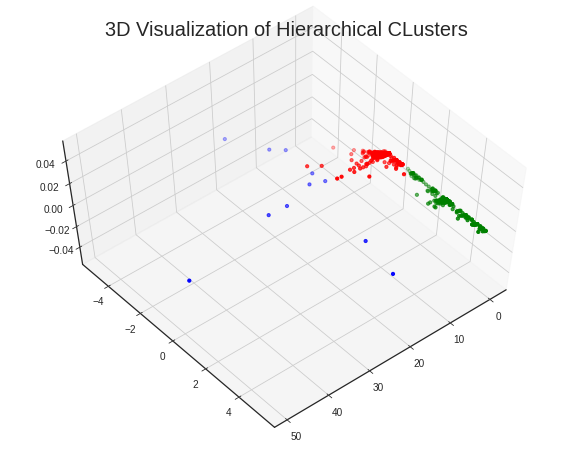

In [63]:
hc_X = pd.DataFrame(X, columns=["pca_one","pca_two"])
hc_X['labels'] = hc_labels

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hc_X.pca_one[hc_X.labels == 0], hc_X.pca_two[hc_X.labels == 0], c='blue', s=10)
ax.scatter(hc_X.pca_one[hc_X.labels == 1], hc_X.pca_two[hc_X.labels == 1], c='red', s=10)
ax.scatter(hc_X.pca_one[hc_X.labels == 2], hc_X.pca_two[hc_X.labels == 2], c='green', s=10)
ax.set_title("3D Visualization of Hierarchical CLusters", fontdict={'fontsize':20})
ax.view_init(60, 50)
fig.show()

Comparing the three clusters, KMeans, EM and Agglomerative, to visualize which algorithm probably clusters better

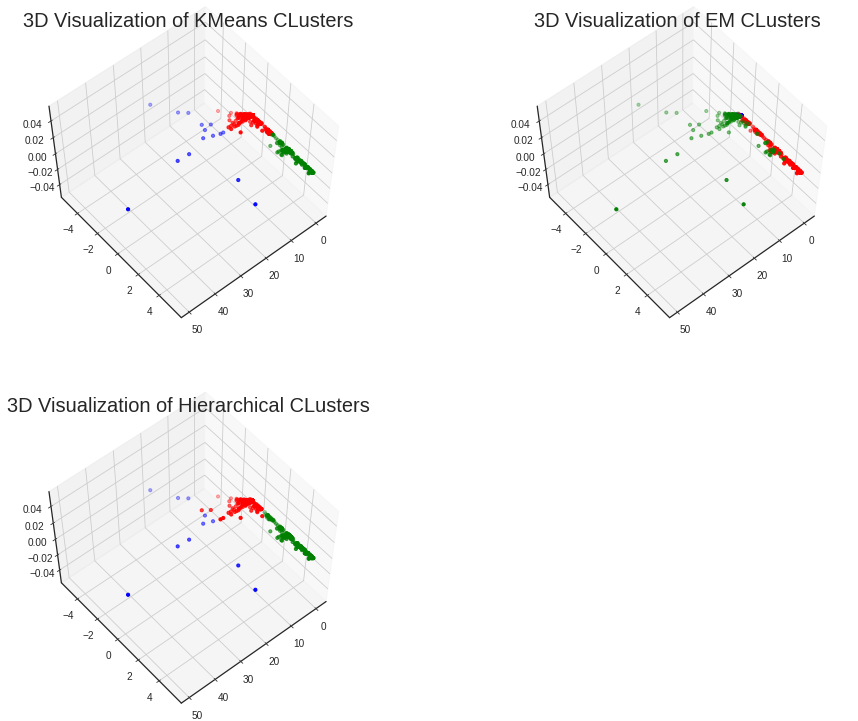

In [67]:
fig = plt.figure(figsize=(15,13))


ax = fig.add_subplot(2,2,1, projection='3d')
ax.scatter(new_X.pca_one[new_X.labels == 0], new_X.pca_two[new_X.labels == 0], c='blue', s=10)
ax.scatter(new_X.pca_one[new_X.labels == 1], new_X.pca_two[new_X.labels == 1], c='red', s=10)
ax.scatter(new_X.pca_one[new_X.labels == 2], new_X.pca_two[new_X.labels == 2], c='green', s=10)
ax.set_title("3D Visualization of KMeans CLusters", fontdict={'fontsize':20})
ax.view_init(60, 50)

ax = fig.add_subplot(2,2,2, projection='3d')
plt.subplots_adjust(wspace=0.4)
ax.scatter(gmm_X.pca_one[gmm_X.labels == 0], gmm_X.pca_two[gmm_X.labels == 0], c='blue', s=10)
ax.scatter(gmm_X.pca_one[gmm_X.labels == 1], gmm_X.pca_two[gmm_X.labels == 1], c='red', s=10)
ax.scatter(gmm_X.pca_one[gmm_X.labels == 2], gmm_X.pca_two[gmm_X.labels == 2], c='green', s=10)
ax.set_title("3D Visualization of EM CLusters", fontdict={'fontsize':20})
ax.view_init(60, 50)

plt.subplot(2,2,3)
ax = fig.add_subplot(2,2,3, projection='3d')
ax.scatter(hc_X.pca_one[hc_X.labels == 0], hc_X.pca_two[hc_X.labels == 0], c='blue', s=10)
ax.scatter(hc_X.pca_one[hc_X.labels == 1], hc_X.pca_two[hc_X.labels == 1], c='red', s=10)
ax.scatter(hc_X.pca_one[hc_X.labels == 2], hc_X.pca_two[hc_X.labels == 2], c='green', s=10)
ax.set_title("3D Visualization of Hierarchical CLusters", fontdict={'fontsize':20})
ax.view_init(60, 50)

fig.show()

As shown above by the visualization comparison, I'll definitely conclude that kmeans makes the best cluster. However we have to know the reasons why right?

But before then lets see how RFM method of clustering would cluster the dataset.

In [69]:
dataset.head()

CustomerID  Total Purchase  Frequency  Product_count  Country
0    12347.0         4310.00        182           2458  Iceland
1    12348.0         1797.24         31           2341  Finland
2    12349.0         1757.55         73            631    Italy
3    12350.0          334.40         17            197   Norway
4    12352.0         1665.74         82            533   Norway